In [8]:
%pylab inline
import os
import pandas as pd
import numpy as np
from Bio.PDB.vectors import Vector
from Bio.PDB.vectors import calc_dihedral
from collections import defaultdict
import random
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


/Users/chingchinglam/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [9]:
#compiled code for model1 
#k-nearest neighbors; k = 3 - approach 2 


def normalize_column(df):
    max_df=max(df['G_kcal'])
    min_df=min(df['G_kcal'])
    df['nor_delG']=df['G_kcal'].apply(lambda x: (x-min_df)/(max_df-min_df))
    #df['label_delG']=df['nor_delG'].apply(lambda x: 1 if x<0.33 else ( 2 if x < 0.66 else 3))
    df['label_delG']=df['nor_delG'].apply(lambda x: 1 if x<0.2 else 0)
    return df 

def pre_processing(filename):
    df=pd.read_csv(filename)
    app_df= df[df['rotamer']=='app']
    exo_df= df[df['rotamer']=='syn_exo']
    endo_df= df[df['rotamer']=='syn_endo']

    nor_app_df=normalize_column(app_df)
    nor_exo_df=normalize_column(exo_df)
    nor_endo_df=normalize_column(endo_df)
    norm_df=pd.concat([nor_exo_df,nor_endo_df, nor_app_df])
    
    features=list(zip(norm_df.value1,norm_df.value2,norm_df.value3,norm_df.value4))
    label= list(norm_df.label_delG)
    
    return features, label, norm_df


OTDS_simple=pre_processing('/Users/chingchinglam/Desktop/iminium/ring-out.csv') #path to the training data 


otds_feature=OTDS_simple[0]
otds_label=OTDS_simple[1]
otds_df=OTDS_simple[2]

model1 = KNeighborsClassifier(n_neighbors=3)
model1.fit(otds_feature, otds_label)

###################

def dihedral_angle_value(atom_of_interest):
    list1=atom_of_interest[0]
    list2=atom_of_interest[1]
    list3=atom_of_interest[2]
    list4=atom_of_interest[3]
    di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
    
    return di_angle

#find the dihedral angle value functions compiles 
def dihedral_angle_value_com(structure_xyz,atom_list):
    
    atom_of_interest=atom_of_interst_formating(structure_xyz,atom_list)

    atom_of_interest_sort=sort_list(atom_list,atom_of_interest)
    
    result = dihedral_angle_value(atom_of_interest_sort)
    
    return result 


<ipython-input-9-d900cc15f42e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nor_delG']=df['G_kcal'].apply(lambda x: (x-min_df)/(max_df-min_df))
<ipython-input-9-d900cc15f42e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_delG']=df['nor_delG'].apply(lambda x: 1 if x<0.2 else 0)


In [10]:
def parse_line(number, string):
    stringa=string.split() 

    for index in range(1, 4):
        stringa[index] = float(stringa[index])

    lista = [number]+[stringa[0]]+[stringa[1:4]]
    
    return lista

#parse_line(1, 'C          1.07360        2.08400        2.15270')



###################

#calculate the dihedral angle - from biopython package 
def dihedral_angle(list_A1, list_A2, list_B1, list_B2):


    a = Vector(list_A1[0]   ,list_A1[1] , list_A1[2]) 
    b = Vector(list_A2[0]   ,list_A2[1] , list_A2[2]) 
    c = Vector(list_B1[0]   ,list_B1[1] , list_B1[2]) 
    d = Vector(list_B2[0]   ,list_B2[1] , list_B2[2])

    di_angle = calc_dihedral(a,b,c,d)* 180.0/pi
    
    return di_angle


##########

#categorize torsional conformers by dihedral angle 
def is_syn_app(atom_of_interest):
    list1=atom_of_interest[0]
    list2=atom_of_interest[1]
    list3=atom_of_interest[2]
    list4=atom_of_interest[3]
    di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
    
    if di_angle >0 and di_angle <100:
        return 'syn_exo'
    elif di_angle == 0:
        return 'syn_exo'
    elif di_angle <0 and di_angle > -100:
        return 'syn_endo'
    else:
        return 'app'

#this should be rename is_E_Z: tell E/Z by dihedral angle 
def is_cis_trans(atom_of_interest):
    list1=atom_of_interest[0]
    list2=atom_of_interest[1]
    list3=atom_of_interest[2]
    list4=atom_of_interest[3]
    di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
    
    if di_angle <90 and di_angle > -90:
        return 'Z'
    elif di_angle == 0:
        return 'Z'
    else:
        return 'E'

#new - pointing towards or away from the large R group 
    
def is_in_out(atom_of_interest):
    list1=atom_of_interest[0]
    list2=atom_of_interest[1]
    list3=atom_of_interest[2]
    list4=atom_of_interest[3]
    di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
    
    result ='out'
    if di_angle < 90 and di_angle > -90:
        result ='in'
    
    return result


def retur_di(atom_of_interest):
    list1=atom_of_interest[0]
    list2=atom_of_interest[1]
    list3=atom_of_interest[2]
    list4=atom_of_interest[3]
    di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
    return di_angle
    
    
def is_para_per(atom_of_interest0,atom_of_interest1,atom_of_interest2,atom_of_interest3):

    
    di_angle0= retur_di(atom_of_interest0)
    di_angle1= retur_di(atom_of_interest1)
    di_angle2= retur_di(atom_of_interest2)
    di_angle3= retur_di(atom_of_interest3)
    
    di_list = [di_angle0,di_angle1,di_angle2,di_angle3]
    
    result='para'
    for i in di_list:
        if i > 60 and i < 110:
            result='per'
        elif i > -110 and i < -60:
            result='per'

    return result
    
    
#################
#ring dectection code 


#possibility generation function - no. of dihedral angles possible within a 5 member ring 

def possibility_generation(atom_list,atom_of_interest):
    atom1_a=atom_list[0].split(' ')
    atom1_b=atom_list[1].split(' ')
    atom1_c=atom_list[2].split(' ')
    atom1_d=atom_list[3].split(' ')
    atom1_e=atom_list[4].split(' ')
    
    number_list = [[1,int(atom1_a[1])], [2,int(atom1_b[1])], [3,int(atom1_c[1])], 
                   [4,int(atom1_d[1])],  [5,int(atom1_e[1])]]
    new=sorted(number_list, key = lambda x: x[1])
    new_list=[i[0] for i in new]

    zipped_lists = zip(new_list, atom_of_interest)

    sorted_zipped_lists = sorted(zipped_lists)

    sorted_list= [element for _, element in sorted_zipped_lists]
    
    N1 = sorted_list[1:]
    C2 = sorted_list[2:]+[sorted_list[0]]
    C3 = sorted_list[3:] +sorted_list[0:2]
    C4 = [sorted_list[-1]] + sorted_list[0:3]
    C5 = sorted_list[0:-1]
    
    possibility_list = [N1, C2, C3, C4, C5]
    
    return possibility_list


# calculate the dihedral angel and generate the result list 
# 0 = twist ring, 1-5=envelope (the number refer to the position of the endo atom)

def what_ring_type(possibility_coor):

    di_angle_result=[]

    for coor_list in possibility_coor:
        list1=coor_list[0]
        list2=coor_list[1]
        list3=coor_list[2]
        list4=coor_list[3]
        di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
        di_angle_result.append(di_angle)

    #print(di_angle_result)
    di_angle_result_ab = list(np.absolute(di_angle_result))
    #print(di_angle_result_ab)
    
    min_position=di_angle_result_ab.index(min(di_angle_result_ab))

    if di_angle_result_ab[min_position]<10: 
        endo_position=min_position+1
    else: 
        endo_position=0
    
    return endo_position


################### compile ring detection code 


def dihedral_angle_test_ring_version(structure_xyz,atom_list1):
    parse_line_list=[]
    atom_of_interest1=[]
    
    atom1_a=atom_list1[0].split(' ')
    atom1_b=atom_list1[1].split(' ')
    atom1_c=atom_list1[2].split(' ')
    atom1_d=atom_list1[3].split(' ')
    atom1_e=atom_list1[4].split(' ')
    
    
    for i in structure_xyz:
        number=structure_xyz.index(i)
        parse_line_list.append(parse_line(number+1, i))
        #print(parse_line_list)

    for j in parse_line_list:
        if j[1] == atom1_a[0] and j[0] == int(atom1_a[1]):
            atom_of_interest1.append(j)
        elif j[1] == atom1_b[0] and j[0] == int(atom1_b[1]):
            atom_of_interest1.append(j)
        elif j[1] == atom1_c[0] and j[0] == int(atom1_c[1]):
            atom_of_interest1.append(j)
        elif j[1] == atom1_d[0] and j[0] == int(atom1_d[1]):
            atom_of_interest1.append(j)
        elif j[1] == atom1_e[0] and j[0] == int(atom1_e[1]):
            atom_of_interest1.append(j)
    
    
    possibility_coor1 = possibility_generation(atom_list1,atom_of_interest1)
    result = what_ring_type(possibility_coor1)
    
    return result 
    
    
#################
    
    
    
def sort_list(atom_list,atom_of_interest):
    atom1_a=atom_list[0].split(' ')
    atom1_b=atom_list[1].split(' ')
    atom1_c=atom_list[2].split(' ')
    atom1_d=atom_list[3].split(' ')
    
    number_list = [[1,int(atom1_a[1])], [2,int(atom1_b[1])], [3,int(atom1_c[1])], [4,int(atom1_d[1])]]
    new=sorted(number_list, key = lambda x: x[1])
    new_list=[i[0] for i in new]
    
    zipped_lists = zip(new_list, atom_of_interest)

    sorted_zipped_lists = sorted(zipped_lists)


    sorted_list1 = [element for _, element in sorted_zipped_lists]
    
    return sorted_list1

#intergrating dihedral_angle_test(structure_xyz,atom_list1) function here 
#if there's error, you need to check both function


def atom_of_interst_formating(structure_xyz,atom_list):
    parse_line_list=[]
    atom_of_interest=[]
    
    atom1_a=atom_list[0].split(' ')
    atom1_b=atom_list[1].split(' ')
    atom1_c=atom_list[2].split(' ')
    atom1_d=atom_list[3].split(' ')
    
        #formating according with parse_line function
    for i in structure_xyz:
        number=structure_xyz.index(i)
        parse_line_list.append(parse_line(number+1, i))
        #print(parse_line_list)
        
    #append parse_line of atoms from the input atom_lists to atom_of_interest list 
    for j in parse_line_list:
        if j[1] == atom1_a[0] and j[0] == int(atom1_a[1]):
            atom_of_interest.append(j)
        elif j[1] == atom1_b[0] and j[0] == int(atom1_b[1]):
            atom_of_interest.append(j)
        elif j[1] == atom1_c[0] and j[0] == int(atom1_c[1]):
            atom_of_interest.append(j)
        elif j[1] == atom1_d[0] and j[0] == int(atom1_d[1]):
            atom_of_interest.append(j)
    
    return atom_of_interest
    
    
def dihedral_angle_test(structure_xyz,atom_list1, atom_list2, atom_list3, atom_list4, atom_list5, atom_list6, atom_list7, atom_list8,atom_list9):

    
    atom_of_interest1=atom_of_interst_formating(structure_xyz,atom_list1)
    atom_of_interest2=atom_of_interst_formating(structure_xyz,atom_list2)
    atom_of_interest4=atom_of_interst_formating(structure_xyz,atom_list4)
    atom_of_interest5=atom_of_interst_formating(structure_xyz,atom_list5)
    atom_of_interest6=atom_of_interst_formating(structure_xyz,atom_list6)
    atom_of_interest7=atom_of_interst_formating(structure_xyz,atom_list7)
    atom_of_interest8=atom_of_interst_formating(structure_xyz,atom_list8)
    atom_of_interest9=atom_of_interst_formating(structure_xyz,atom_list9)

    
    atom_of_interest1_sort=sort_list(atom_list1,atom_of_interest1)
    atom_of_interest2_sort=sort_list(atom_list2,atom_of_interest2)
    atom_of_interest4_sort=sort_list(atom_list4,atom_of_interest4)
    atom_of_interest5_sort=sort_list(atom_list5,atom_of_interest5)
    atom_of_interest6_sort=sort_list(atom_list6,atom_of_interest6)
    atom_of_interest7_sort=sort_list(atom_list7,atom_of_interest7)
    atom_of_interest8_sort=sort_list(atom_list8,atom_of_interest8)
    atom_of_interest9_sort=sort_list(atom_list9,atom_of_interest9)

    
    ring_dectection = dihedral_angle_test_ring_version(structure_xyz,atom_list3)
    

    #result = [is_syn_app(atom_of_interest1_sort) + ' ' + is_cis_trans(atom_of_interest2_sort) +  ' '+ str(ring_dectection)+' '+
            #  is_in_out(atom_of_interest4_sort)+ ' '+is_para_per(atom_of_interest5_sort, atom_of_interest6_sort, atom_of_interest7_sort, atom_of_interest8_sort)]
    #use the above line instead if you wish to include the ring label in the conformation label 
    
    
    result = [is_syn_app(atom_of_interest1_sort) + ' ' + is_cis_trans(atom_of_interest2_sort) +  ' '+
              is_in_out(atom_of_interest4_sort)+ ' '+is_para_per(atom_of_interest5_sort, atom_of_interest6_sort, atom_of_interest7_sort, atom_of_interest8_sort)]
        

    
            
    return result 

    

############################################
    #convert xyz file spacing to gjf spacing 
    
def right_spacing(coor_list):
    coor_list_space=[]
    for cline in coor_list:
        split_coor=cline.split()
        new_coor=''
        space1=18
        space2=4
        space3=4
        if len(split_coor[0]) == 2:
            space1=17
        for o in split_coor:  
            if '-' in o:
                index_list=[]
                index_list.append(split_coor.index(o))
                if 1 in index_list:
                    space1=17
                elif 2 in index_list:
                    space2=3
                elif 3 in index_list:
                    space3=3
        new_coor=str(split_coor[0])+space1*' '+str(split_coor[1])+'000'+space2*' '+str(split_coor[2])+'000'+space3*' '+str(split_coor[3])+'000\n'
        coor_list_space.append(new_coor)
    return coor_list_space





############# post processing 
#Index of duplicates items in a python list from 
#https://stackoverflow.com/questions/5419204/index-of-duplicates-items-in-a-python-list

def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)  
    
    return [[key,locs] for key,locs in tally.items() if len(locs)>0]


def lengths(x):
    length_list=[]
    for u in x: 
        length_list.append(len(u[1]))
    length_list.sort(reverse=True)
    return length_list

def print_graphs(list_duplicates_result):
    data1=[]
    x_axis=[]
    for dup in list_duplicates_result:
        data1.append(len(dup[1]))
        x_axis.append(str(dup[0]))
        
    data = {'cate': x_axis, 'total': data1}
    df = pd.DataFrame(data)
    df.sort_values('total', axis = 0, ascending = False, inplace = True)
    
    print(df)
    plt.bar(df['cate'], df['total'])
    plt.xticks(rotation= 90)
    plt.show()
    

In [11]:
#only for xyz file from maestro macromodel 
#the current script is for cat C & A_OTDS; some changes is required for cat B&A
def category_dih_angle(filename, atom_list1, atom_list2, atom_list3, atom_list4, atom_list5,atom_list6, atom_list7, atom_list8,
                      atom_list9,atom_list10, atom_list11, atom_list12,atom_list13):
    
    ## remove for ',atom_list10, atom_list11, atom_list12,atom_list13' in the above line for cat B & A
    
    xyz_output=[]

    with open(filename) as output:
        for line in output:
            xyz_output+= [line]

    Eopt_index_list =[k for k,d in enumerate(xyz_output) if d=='Molecule Name\n']


    division1=[]
    for j in range(0,len(Eopt_index_list)):
        try:
            a=xyz_output[Eopt_index_list[j]+1: Eopt_index_list[j+1]-1]
            division1.append(a)
        except IndexError:
            b=xyz_output[Eopt_index_list[j]+1:]
            division1.append(b)

    division2=[]
    division3=[]
    for s in division1:
        division2.append(right_spacing(s))
        
    con_label=[]
    value1 =[] 
    value2 =[]
    value3 =[]
    value4 =[]

    for st in division2:
        output=dihedral_angle_test(st,atom_list1, atom_list2, atom_list3, atom_list4, atom_list5, atom_list6, atom_list7, atom_list8, atom_list9)
        con_label.append(output[0])
    
        output1=dihedral_angle_value_com(st,atom_list10) ## remove for cat B & A
        output2=dihedral_angle_value_com(st,atom_list11) ## remove for cat B & A
        output3=dihedral_angle_value_com(st,atom_list12) ## remove for cat B & A
        output4=dihedral_angle_value_com(st,atom_list13) ## remove for cat B & A
        value1.append(output1) ## remove for cat B & A
        value2.append(output2) ## remove for cat B & A
        value3.append(output3) ## remove for cat B & A
        value4.append(output4) ## remove for cat B & A
    
    #k-nearest neighbors test 
    
    feature=list(zip(value1,value2,value3,value4)) ## remove for cat B & A
    prediction=model1.predict(feature) ## remove for cat B & A
    
    comb_label=[] ## remove for cat B & A
    for ind in range(0,len(prediction)): ## remove for cat B & A
        comb_label.append( con_label[ind]+' '+str(prediction[ind])) ## remove for cat B & A
    
    
    
    result = list_duplicates(comb_label) ## change comb_label to con_label for cat B & A
    
    list_len=lengths(result)
    
    chosen_list_len=len(list_len)
    chosen_80th=np.percentile(list_len, 80)
    
    selected_outer=[]
    
    
    # the selection script is as below:
    
    for i in result:
        
        selected_inner=[i[0]]
        
        
        st_number = i[1]
        new_st_number=[]
        for st_no in st_number:
            new_st_number.append(st_no)
        
        new_st_number_plus_one = [o+1 for o in new_st_number]
        
        print(i[0],' --- ', len(new_st_number_plus_one))
        print(new_st_number_plus_one)
        
        try:
            selected_number=[]
        
            if chosen_list_len < 10:
                if len(new_st_number_plus_one) in list_len[0:3]:
                    randomlist2 = random.sample(range(0, len(new_st_number_plus_one)), 2)
                    for n2_10 in randomlist2:
                        selected_number.append(new_st_number_plus_one[n2_10])
                else: 
                    randomlist1 = random.sample(range(0, len(new_st_number_plus_one)), 1)
                    for n1_10 in randomlist1:
                        selected_number.append(new_st_number_plus_one[n1_10])
        
            else:
                if len(new_st_number_plus_one) in list_len[0:2]:
                    randomlist3 = random.sample(range(0, len(new_st_number_plus_one)), 3)
                    for n3 in randomlist3:
                        selected_number.append(new_st_number_plus_one[n3])
                    
                elif  len(new_st_number_plus_one) < chosen_80th:
                    randomlist1 = random.sample(range(0, len(new_st_number_plus_one)), 1)
                    for n1 in randomlist1:
                        selected_number.append(new_st_number_plus_one[n1])       
                else:  
                    randomlist2 = random.sample(range(0, len(new_st_number_plus_one)), 2)
                    for n2 in randomlist2:
                        selected_number.append(new_st_number_plus_one[n2])
        
        except ValueError:
            print('ValueError')
            
        
        selected_inner.append(selected_number)
        selected_outer.append(selected_inner)
    
    all_select_no=[1]
    for set_list in  selected_outer:
        p_list=set_list[1]
        for p in p_list:
            all_select_no.append(p)
    
    print()
    print(selected_outer)
    print()
    print('input to the gjf generation script:')
    
    print(all_select_no)   
    
    print('##############')
    print()
    print('length of the list: '+ str(len(all_select_no)))
    print('number of unique conformation labels: '+ str(chosen_list_len))
    print()
    print_graphs(result)
    return selected_outer


In [12]:
#only for xyz file from maestro macromodel 
#the current script is for cat B&A; some changes is required for cat C & A_OTDS
def category_dih_angle_B(filename, atom_list1, atom_list2, atom_list3, atom_list4, atom_list5,atom_list6, atom_list7, atom_list8,
                      atom_list9):
    
    ## remove for ',atom_list10, atom_list11, atom_list12,atom_list13' in the above line for cat B & A
    
    xyz_output=[]

    with open(filename) as output:
        for line in output:
            xyz_output+= [line]

    Eopt_index_list =[k for k,d in enumerate(xyz_output) if d=='Molecule Name\n']


    division1=[]
    for j in range(0,len(Eopt_index_list)):
        try:
            a=xyz_output[Eopt_index_list[j]+1: Eopt_index_list[j+1]-1]
            division1.append(a)
        except IndexError:
            b=xyz_output[Eopt_index_list[j]+1:]
            division1.append(b)

    division2=[]
    division3=[]
    for s in division1:
        division2.append(right_spacing(s))
        
    con_label=[]
    value1 =[] 
    value2 =[]
    value3 =[]
    value4 =[]

    for st in division2:
        output=dihedral_angle_test(st,atom_list1, atom_list2, atom_list3, atom_list4, atom_list5, atom_list6, atom_list7, atom_list8, atom_list9)
        con_label.append(output[0])
    
        #output1=dihedral_angle_value_com(st,atom_list10) ## remove for cat B & A
        #output2=dihedral_angle_value_com(st,atom_list11) ## remove for cat B & A
        #output3=dihedral_angle_value_com(st,atom_list12) ## remove for cat B & A
        #output4=dihedral_angle_value_com(st,atom_list13) ## remove for cat B & A
        #value1.append(output1) ## remove for cat B & A
        #value2.append(output2) ## remove for cat B & A
        #value3.append(output3) ## remove for cat B & A
        #value4.append(output4) ## remove for cat B & A
    
    #k-nearest neighbors test 
    
    #feature=list(zip(value1,value2,value3,value4)) ## remove for cat B & A
    #prediction=model1.predict(feature) ## remove for cat B & A
    
    #comb_label=[] ## remove for cat B & A
    #for ind in range(0,len(prediction)): ## remove for cat B & A
     #   comb_label.append( con_label[ind]+' '+str(prediction[ind])) ## remove for cat B & A
    
    
    
    result = list_duplicates(con_label) ## change comb_label to con_label for cat B & A
    
    list_len=lengths(result)
    
    chosen_list_len=len(list_len)
    chosen_80th=np.percentile(list_len, 80)
    
    selected_outer=[]
    
    
    # the selection script is as below:
    
    for i in result:
        
        selected_inner=[i[0]]
        
        
        st_number = i[1]
        new_st_number=[]
        for st_no in st_number:
            new_st_number.append(st_no)
        
        new_st_number_plus_one = [o+1 for o in new_st_number]
        
        print(i[0],' --- ', len(new_st_number_plus_one))
        print(new_st_number_plus_one)
        
        try:
            selected_number=[]
        
            if chosen_list_len < 10:
                if len(new_st_number_plus_one) in list_len[0:3]:
                    randomlist2 = random.sample(range(0, len(new_st_number_plus_one)), 2)
                    for n2_10 in randomlist2:
                        selected_number.append(new_st_number_plus_one[n2_10])
                else: 
                    randomlist1 = random.sample(range(0, len(new_st_number_plus_one)), 1)
                    for n1_10 in randomlist1:
                        selected_number.append(new_st_number_plus_one[n1_10])
        
            else:
                if len(new_st_number_plus_one) in list_len[0:2]:
                    randomlist3 = random.sample(range(0, len(new_st_number_plus_one)), 3)
                    for n3 in randomlist3:
                        selected_number.append(new_st_number_plus_one[n3])
                    
                elif  len(new_st_number_plus_one) < chosen_80th:
                    randomlist1 = random.sample(range(0, len(new_st_number_plus_one)), 1)
                    for n1 in randomlist1:
                        selected_number.append(new_st_number_plus_one[n1])       
                else:  
                    randomlist2 = random.sample(range(0, len(new_st_number_plus_one)), 2)
                    for n2 in randomlist2:
                        selected_number.append(new_st_number_plus_one[n2])
        
        except ValueError:
            print('ValueError')
            
        
        selected_inner.append(selected_number)
        selected_outer.append(selected_inner)
    
    all_select_no=[1]
    for set_list in  selected_outer:
        p_list=set_list[1]
        for p in p_list:
            all_select_no.append(p)
    
    print()
    print(selected_outer)
    print()
    print('input to the gjf generation script:')
    
    print(all_select_no)   
    
    print('##############')
    print()
    print('length of the list: '+ str(len(all_select_no)))
    print('number of unique conformation labels: '+ str(chosen_list_len))
    print()
    print_graphs(result)
    return selected_outer

app E in per  ---  17
[1, 2, 3, 4, 5, 6, 14, 16, 19, 23, 26, 30, 31, 186, 187, 305, 428]
app E out per  ---  23
[7, 8, 9, 10, 11, 51, 56, 63, 66, 67, 69, 82, 84, 97, 102, 258, 385, 389, 395, 575, 576, 577, 579]
syn_exo E out per  ---  43
[12, 13, 15, 17, 18, 20, 21, 22, 24, 25, 61, 62, 65, 68, 70, 71, 73, 77, 80, 86, 89, 91, 93, 95, 96, 113, 125, 133, 136, 139, 142, 144, 236, 240, 241, 253, 260, 264, 265, 267, 272, 274, 279]
syn_exo E in per  ---  88
[27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 55, 57, 58, 59, 60, 64, 72, 74, 75, 76, 78, 79, 81, 83, 85, 87, 88, 90, 92, 94, 104, 107, 111, 112, 118, 119, 120, 123, 128, 130, 131, 134, 141, 143, 145, 148, 149, 152, 153, 154, 157, 158, 159, 161, 163, 165, 167, 168, 169, 170, 171, 172, 173, 185, 245, 328, 329, 333, 392, 393, 397, 402, 403, 408]
app E out para  ---  11
[47, 166, 327, 330, 352, 354, 525, 534, 535, 609, 611]
app Z in para  ---  13
[98, 99, 101, 164, 430, 434, 436, 440, 582, 58

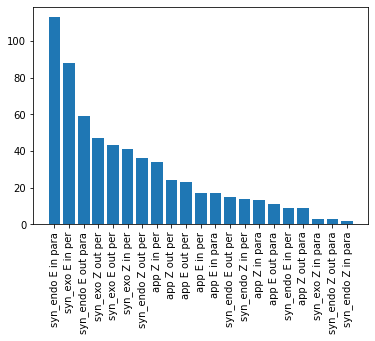

[['app E in per', [23]],
 ['app E out per', [7]],
 ['syn_exo E out per', [61, 93]],
 ['syn_exo E in per', [157, 170, 154]],
 ['app E out para', [611]],
 ['app Z in para', [430]],
 ['app Z in per', [524]],
 ['syn_endo E out para', [117, 233]],
 ['app E in para', [450]],
 ['syn_exo Z in per', [462]],
 ['syn_endo E in para', [180, 280, 252]],
 ['syn_endo Z in per', [339]],
 ['syn_endo E in per', [415]],
 ['app Z out per', [340]],
 ['app Z out para', [273]],
 ['syn_endo E out per', [538]],
 ['syn_exo Z out per', [608, 390]],
 ['syn_exo Z in para', [423]],
 ['syn_endo Z in para', [421]],
 ['syn_endo Z out per', [542]],
 ['syn_endo Z out para', [602]]]

In [13]:
atom_list1=['N 3','C 6', 'C 9','O 34']
atom_list2=['C 1','C 2', 'N 3','C 6']
atom_list3=['N 3','C 6','C 8','C 11', 'C 7']
atom_list4=['C 46','C 44', 'C 6','C 9']
atom_list5=['O 34','C 9', 'C 25','C 27']
atom_list6=['O 34','C 9', 'C 25','C 26']
atom_list7=['O 34','C 9', 'C 16','C 17']
atom_list8=['O 34','C 9', 'C 16','C 18']
atom_list9=['C 54','C 44', 'C 1','C 2']

category_dih_angle_B('B_Me_RMe_R.xyz', atom_list1, atom_list2, atom_list3, atom_list4, 
                   atom_list5, atom_list6,atom_list7, atom_list8, atom_list9)


app E in per 0  ---  393
[1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 37, 38, 40, 42, 44, 45, 47, 49, 51, 53, 54, 55, 59, 60, 61, 62, 63, 64, 65, 66, 68, 70, 72, 74, 75, 77, 78, 81, 82, 84, 85, 88, 90, 91, 93, 94, 95, 96, 98, 99, 101, 104, 109, 110, 111, 114, 121, 122, 123, 126, 127, 144, 152, 157, 158, 160, 164, 165, 166, 168, 169, 170, 172, 177, 178, 179, 180, 181, 182, 184, 185, 189, 191, 192, 193, 195, 196, 197, 198, 199, 200, 202, 205, 206, 208, 210, 211, 212, 215, 216, 219, 220, 222, 224, 226, 229, 230, 231, 238, 240, 241, 243, 245, 246, 247, 248, 250, 253, 255, 256, 257, 262, 265, 266, 267, 268, 273, 275, 276, 279, 281, 282, 284, 287, 290, 294, 295, 298, 302, 303, 308, 310, 311, 312, 314, 315, 317, 318, 319, 321, 322, 327, 328, 330, 331, 334, 337, 338, 339, 341, 343, 344, 346, 348, 349, 352, 354, 357, 358, 359, 361, 365, 371, 373, 374, 375, 376, 378, 383, 385, 388, 394, 395, 397, 398, 406, 411, 412, 416, 418, 419, 422, 4

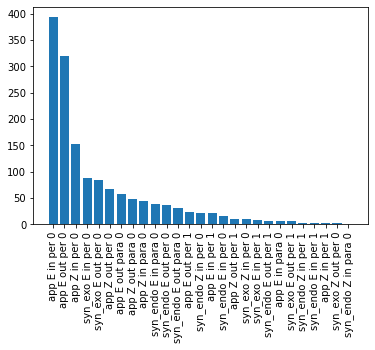

In [14]:
atom_list1=['N 3','C 6', 'C 9','O 36']
atom_list2=['C 1','C 2', 'N 3','C 6']
atom_list3=['N 3','C 6','C 8','C 11', 'C 7']
atom_list4=['C 67','C 65', 'C 6','C 9']
atom_list5=['O 36','C 9', 'C 27','C 28']
atom_list6=['O 36','C 9', 'C 27','C 29']
atom_list7=['O 36','C 9', 'C 18','C 20']
atom_list8=['O 36','C 9', 'C 18','C 19']
atom_list9=['C 85','C 65', 'C 1','C 2']

atom_list10=['Si 37', 'C 46','C 51','H 52']
atom_list11=['O 36','Si 37', 'C 46','C 51']
atom_list12=['C 9','O 36','Si 37', 'C 46']
atom_list13=['C 6','C 9','O 36','Si 37']



C_Me_RMe_R=category_dih_angle('C_Me_RMe_R.xyz', atom_list1, atom_list2, atom_list3, atom_list4, 
                   atom_list5, atom_list6,atom_list7, atom_list8, atom_list9,atom_list10,
                           atom_list11, atom_list12, atom_list13)